In [1]:
import warnings
warnings.filterwarnings('ignore')

SEED = 42
SAMPLE_RATE = 2000 # Hz
SKIP_SECONDS = 5 # sec
TIME_LENGTH = 6 # sec
OVERLAP_SECONDS = 2 # sec
# SCALING = True
SCALING = False
TYPE_ANOMALY_DETECTION = "Novelty"
# TYPE_ANOMALY_DETECTION = "Outlier"
# TYPE_DOMAIN = "freq"
TYPE_DOMAIN = "time"

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# load X_raw_data.pkl, y_raw_data.pkl
with open("X_raw_data.pkl", "rb") as file:
    X_raw_data = pickle.load(file)

with open("y_raw_data.pkl", "rb") as file:
    y_raw_data = pickle.load(file)
    
for arr in X_raw_data:
    arr[:, 2] += 1000

def process_time_series_with_overlap(data, sample_rate=2000, skip_seconds=5, segment_seconds=6, overlap_seconds=2):
    """
    處理 time series data，去除開頭資料並切分成固定長度、具有 overlap 的片段。
    
    :param data: numpy array, shape = (length, 3)
    :param sample_rate: 採樣率, 預設 2000 Hz
    :param skip_seconds: 開頭跳過的秒數, 預設 5 秒
    :param segment_seconds: 每段切分的秒數, 預設 6 秒
    :param overlap_seconds: 每段之間的重疊秒數, 預設 2 秒
    :return: 切分後的資料列表，每個元素為 numpy array
    """
    # 計算需要跳過的資料行數
    skip_rows = skip_seconds * sample_rate
    # 計算每段的行數
    segment_rows = segment_seconds * sample_rate
    # 計算每次移動的步數 (segment_rows - overlap_rows)
    overlap_rows = overlap_seconds * sample_rate
    step_rows = segment_rows - overlap_rows

    # 去掉開頭的資料
    data = data[skip_rows:]
    
    # 切分資料，加入 overlap
    segments = [data[i:i + segment_rows] for i in range(0, len(data) - segment_rows + 1, step_rows)]
    
    # return segments[0:1]
    return segments

In [3]:
good_indices = [index for index, value in enumerate(y_raw_data) if 'good' in value]
bad_indices = [index for index, value in enumerate(y_raw_data) if 'bad' in value]

In [4]:
import random
random.seed(SEED)

good_test_indices = random.sample(good_indices, len(bad_indices))
good_train_indices = [i for i in good_indices if i not in good_test_indices]
good_train_indices.sort(), good_test_indices.sort()
len(good_train_indices), len(good_test_indices), len(bad_indices)

(1562, 70, 70)

In [5]:
# X_raw_data 分成 X_raw_good, X_raw_bad
# X_raw_good 分成 X_raw_good_train, X_raw_good_test

X_raw_good_train = []
X_raw_good_test = []
X_raw_bad = [] 

for i in good_train_indices:
    X_raw_good_train.extend(process_time_series_with_overlap(X_raw_data[i], SAMPLE_RATE, SKIP_SECONDS, TIME_LENGTH, OVERLAP_SECONDS))

for i in good_test_indices:
    X_raw_good_test.extend(process_time_series_with_overlap(X_raw_data[i], SAMPLE_RATE, SKIP_SECONDS, TIME_LENGTH, OVERLAP_SECONDS))

for i in bad_indices:
    X_raw_bad.extend(process_time_series_with_overlap(X_raw_data[i], SAMPLE_RATE, SKIP_SECONDS, TIME_LENGTH, OVERLAP_SECONDS))

# X_data1 = np.array(X_data)
# X_data_abs = np.abs(X_data1)
# x_abs_max, y_abs_max, z_abs_max = X_data_abs[:,:,0].max(), X_data_abs[:,:,1].max(), X_data_abs[:,:,2].max()

# ## Scaling
# if SCALING:
#     for i,m_i in enumerate([x_abs_max, y_abs_max, z_abs_max]):
#         X_data1[:,:,i] = X_data1[:,:,i]/m_i

In [6]:
len(X_raw_good_train), len(X_raw_good_test), len(X_raw_bad)

(17186, 777, 543)

In [7]:
X_good_train = np.array(X_raw_good_train)
X_good_test = np.array(X_raw_good_test)
X_bad = np.array(X_raw_bad)

In [8]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# with tf.device('/CPU:0'):
    # 加載 Keras 格式模型
autoencoder_model0 = load_model(f'autoencoder_model_{TYPE_DOMAIN}.keras', compile=False)
autoencoder_model0.summary()

2025-01-19 19:02:53.757948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 19:02:54.614947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-01-19 19:02:54.615065: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-01-19 19:02:54.615074: W tensorflow/compiler/tf2tensorrt/util

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12000, 3)]        0         
                                                                 
 encoder (Functional)        (None, 666)               8521      
                                                                 
 decoder (Functional)        (None, 12000, 3)          1341843   
                                                                 
Total params: 1,350,364
Trainable params: 1,349,960
Non-trainable params: 404
_________________________________________________________________


In [9]:
encoder_model = autoencoder_model0.get_layer('encoder')
encoder_model.summary()
decoder_model = autoencoder_model0.get_layer('decoder')
decoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12000, 3)]        0         
                                                                 
 conv1d (Conv1D)             (None, 12000, 127)        1270      
                                                                 
 batch_normalization (BatchN  (None, 12000, 127)       508       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 12000, 127)        0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4000, 127)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4000, 11)          4202

In [10]:
# with tf.device('/GPU:0'): 
#     encoder_model = autoencoder_model0.get_layer('encoder')
#     encoder_model.summary()
# with tf.device('/GPU:0'):
#     decoder_model = autoencoder_model0.get_layer('decoder')
#     decoder_model.summary()

In [11]:
# with tf.device('/CPU:0'):
#     # 提取 encoder 層
#     encoder_model = autoencoder_model0.get_layer('encoder')
#     # 檢查 encoder model 的架構
#     encoder_model.summary()
#     # 使用 encoder 進行推理
#     # encoded_output = encoder_model.predict(X_bad)

# with tf.device('/CPU:0'):
#     decoder_model = autoencoder_model0.get_layer('decoder')
#     # 檢查 decoder model 的架構
#     decoder_model.summary()

In [12]:
decoder_model.input_shape[1]

666

In [13]:
# from tensorflow.keras import layers, models

# autoencoder = models.Sequential([
#     encoder_model,
#     layers.Dense(128, activation='relu'),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(decoder_model.input_shape[1], activation='linear'),
#     decoder_model
# ])
# autoencoder.summary()

In [14]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score
)
import tensorflow as tf
from tensorflow.keras import layers, models


# 模擬資料
X_test = np.vstack([X_good_test, X_bad])
y_test = np.array([0] * len(X_good_test) + [1] * len(X_bad))

# 訓練資料（僅正常資料）
X_train = X_good_train

# 記錄每個模型的結果
results = {}

from tensorflow.keras.callbacks import EarlyStopping

# 定義 Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',  # 監控的指標（可以是 'val_loss', 'loss', 或其他 metric）
    patience=20,          # 容忍幾個 epoch 無改善
    verbose=1,           # 是否顯示早停的訊息
    restore_best_weights=True  # 是否恢復為最佳權重
)
# 訓練 AutoEncoder
start_time = time.time()
input_dim = X_train.shape[1]
autoencoder = models.Sequential([
    encoder_model,
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(decoder_model.input_shape[1], activation='linear'),
    decoder_model
])
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(
    X_train, 
    X_train, 
    epochs=100, 
    batch_size=16, 
    shuffle=True, 
    validation_split=0.2, 
    callbacks=[early_stop]  # 加入 Early Stopping
)

2025-01-19 19:03:07.748177: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1979712000 exceeds 10% of free system memory.
2025-01-19 19:03:11.063757: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1979712000 exceeds 10% of free system memory.
2025-01-19 19:03:13.302760: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1979712000 exceeds 10% of free system memory.
2025-01-19 19:03:15.194966: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1979712000 exceeds 10% of free system memory.


Epoch 1/100


2025-01-19 19:05:44.063174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2025-01-19 19:05:44.805196: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x300efcf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-19 19:05:44.805261: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GRID P40-24Q, Compute Capability 6.1
2025-01-19 19:05:44.811541: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-19 19:05:44.932332: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


860/860 [==============================] - 239s 103ms/step - loss: 70103.7109 - val_loss: 78505.8281
Epoch 2/100
860/860 [==============================] - 84s 98ms/step - loss: 62025.8281 - val_loss: 75426.2188
Epoch 3/100
860/860 [==============================] - 86s 100ms/step - loss: 60099.4141 - val_loss: 74917.3359
Epoch 4/100
860/860 [==============================] - 87s 102ms/step - loss: 58995.8203 - val_loss: 73910.1719
Epoch 5/100
860/860 [==============================] - 87s 101ms/step - loss: 58174.2422 - val_loss: 73305.0078
Epoch 6/100
860/860 [==============================] - 86s 101ms/step - loss: 57561.3477 - val_loss: 73022.8047
Epoch 7/100
860/860 [==============================] - 87s 101ms/step - loss: 57024.9492 - val_loss: 72673.2891
Epoch 8/100
860/860 [==============================] - 87s 101ms/step - loss: 56634.4336 - val_loss: 72468.9453
Epoch 9/100
860/860 [==============================] - 87s 101ms/step - loss: 56174.0781 - val_loss: 72423.7422
Epoc

KeyboardInterrupt: 

In [15]:
# 获取训练过程中的 loss 值
loss_values = history.history['loss']
# 绘制损失曲线
plt.plot(range(1, len(loss_values) + 1), loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.grid(True)
plt.show()
# save the plot to file
plt.savefig(f'loss_plot_{TYPE_DOMAIN}_train1.png')

NameError: name 'history' is not defined

In [16]:
reconstructions = autoencoder.predict(X_test)
autoencoder_scores = np.mean(np.square(X_test - reconstructions), axis=(1,2))
results["AutoEncoder"] = {
    "scores": autoencoder_scores,
    "time": time.time() - start_time
}

42/42 [==============================] - 3s 32ms/step


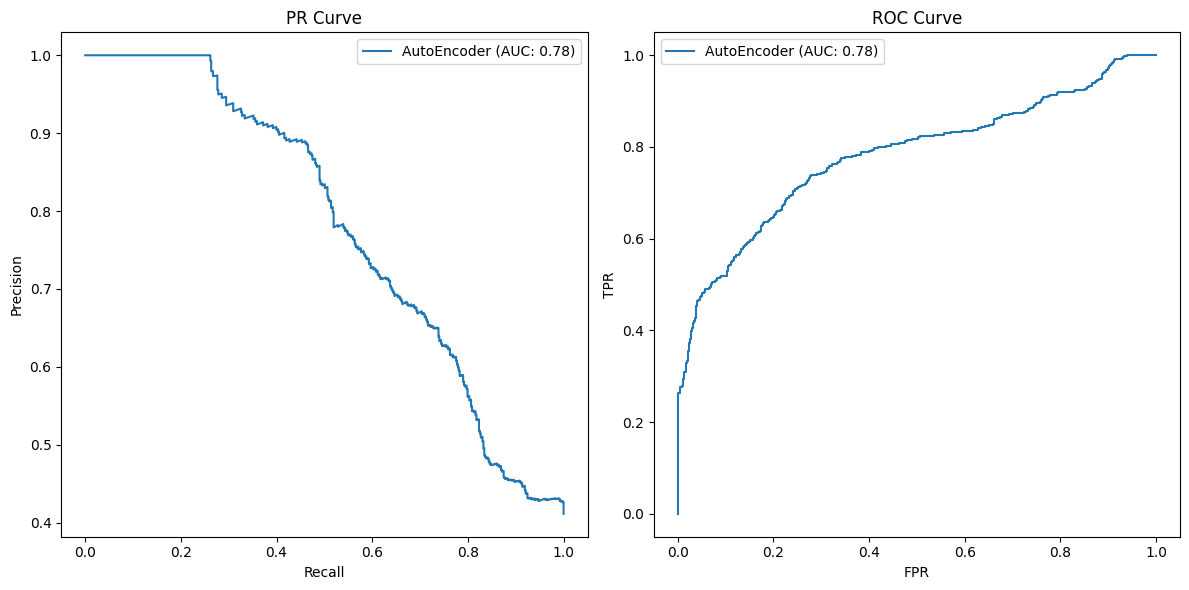

AutoEncoder: Best F1-Score: 0.68, Threshold: 62685.96
Training time: 5814.63 seconds


<Figure size 640x480 with 0 Axes>

In [19]:
# 繪製 PR 曲線和 ROC 曲線
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # PR Curve
for model, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result["scores"])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{model} (AUC: {pr_auc:.2f})")
plt.title("PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.subplot(1, 2, 2)  # ROC Curve
for model, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result["scores"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model} (AUC: {roc_auc:.2f})")
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.tight_layout()
plt.show()

# 計算 F1-Score 曲線並顯示模型訓練時間
for model, result in results.items():
    scores = result["scores"]
    thresholds = np.linspace(min(scores), max(scores), 100)
    f1_scores = [f1_score(y_test, scores >= t) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"{model}: Best F1-Score: {max(f1_scores):.2f}, Threshold: {best_threshold:.2f}")
    print(f"Training time: {result['time']:.2f} seconds")
    
# Save figures
plt.savefig(f"PR_ROC_curve_{TYPE_DOMAIN}_train1.png")

In [26]:
# save the autoencoder model
autoencoder.save(f'autoencoder_model_{TYPE_DOMAIN}_train1.keras')

ValueError: Unable to synchronously create dataset (name already exists)

In [27]:
X_good_train.shape, X_good_test.shape, X_bad.shape

((17186, 12000, 3), (777, 12000, 3), (543, 12000, 3))

In [28]:
X_all = np.vstack([X_good_train, X_good_test, X_bad])
X_all.shape

(18506, 12000, 3)

In [29]:
y_all = [0]*(len(X_good_train)+len(X_good_test))+[1]*(len(X_bad))
len(y_all)

18506

In [30]:
X_data_encode = encoder_model.predict(X_all)

2025-01-19 20:43:28.674572: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2664864000 exceeds 10% of free system memory.


579/579 [==============================] - 10s 18ms/step


In [31]:
X_data_encode.shape

(18506, 666)

In [32]:
# save the encoded data
np.save(f'X_data_encode_{TYPE_DOMAIN}_train1.npy', X_data_encode)

In [33]:
np.save(f'y_data_{TYPE_DOMAIN}_train1.npy', y_all)